# Casos de Uso

# Analisis Tiempo Real Precio Oro KafkaProducer

## Instalación librerías

In [ ]:
!!curl -sSOL https://dlcdn.apache.org/kafka/3.1.0/kafka_2.13-3.1.0.tgz
!tar -xzf kafka_2.13-3.1.0.tgz

In [ ]:
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
!ps -ef | grep kafka

root         469       1 14 23:57 ?        00:00:01 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.1.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.1.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.1.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.1.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

Creamos un topico llamado "Goldrates"

In [ ]:
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic Goldrates

Created topic Goldrates.


Instalamos KafkaProducer en python

In [ ]:
!pip install kafka-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 25.3 MB/s 


In [ ]:
import time
import json
import kafka
import pandas as pd
import requests as req
from kafka import KafkaProducer,KafkaConsumer
from kafka.errors import KafkaError
from random import *
from json import dumps
from time import sleep

In [ ]:
ticker_url="https://forex-data-feed.swissquote.com/public-quotes/bboquotes/instrument/XAU/USD"
topic='Goldrates'
sleep_time=1

Nos conectamos al servidor de kafka.

In [ ]:
producer = KafkaProducer(bootstrap_servers=['ec2-18-118-112-10.us-east-2.compute.amazonaws.com'],value_serializer=lambda x: dumps(x).encode('utf-8'))

In [ ]:
producer

Haremos un requerimiento al ticket de forex-data para obtener los precios del oro con respecto al precio dolar XAU/USD. La información extraida del ticker será guardada en formato json y enviada por Kafka.

In [ ]:
while(True):
    print("Obteniendo nuevos datos...")
    #request de la data de precios
    resp = req.get(ticker_url)
    #convertir a formato json
    json_data = json.loads(resp.text)
    print(json_data)
    #enviar con kafka
    producer.send(topic, json_data)
    #1 segundo de pausa
    time.sleep(sleep_time)

#Consumidor de los datos generados en notebook "CasoUso_AnalisisTiempoRealPrecioOro_KafkaProducer"

In [ ]:
!pip install kafka-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 5.3 MB/s 


In [ ]:
import time
import json
import kafka
from kafka import KafkaProducer,KafkaConsumer
from kafka.errors import KafkaError
from pandas import DataFrame
from datetime import datetime
from random import *
import matplotlib.pyplot as plt

Nos conectamos al servidor de Kafka y preguntamos por los tópicos existentes.

In [ ]:
admin_client = kafka.KafkaAdminClient(bootstrap_servers=['ec2-18-118-112-10.us-east-2.compute.amazonaws.com'])
L = admin_client.list_topics()
print(L)

['G2-grupo5', 'G2-alarmas4-1', 'G2-alarmas4', 'Images3', 'G2-grupo1', 'G3-grupo5', 'grupo1', 'fotos', 'Sales', 'G3-grupo5-test', 'alarmas', 'diplomado', 'Images2', 'G3-grupo5-test2', 'G3-grupo1', 'grupo4', 'G2-grupo4', 'diplomaddas', 'G2-alarmas1', 'G3-grupo4', 'G2-alarmas3', 'G2-grupo2G2', 'CSV', 'G2-2', 'grupo5', '__consumer_offsets', 'G3-grupoX', 'G2-grupo3', 'G2-alarmas2', 'G2-Grupo3', 'grupo6', 'XXXX', 'G2-grupo7', 'G3-grupo3', 'G3', 'G2-alarmas6', 'grupo2', 'G3-grupo7', 'RUL_25', 'G2-alarmas', 'G2-alarmas5', 'wiki', 'wiki_2', 'RUL', 'grupo7', 'G2-g1_alarmas_test', 'G2-grupo2', 'images', 'G1-grupo5', 'grupo3', 'Images22', 'G2-grupo6', 'G3-grupo6', 'G2-grupo4-1', 'wiki-7', 'G3-ALARMA', 'Goldrates', 'G3-grupo2', 'G2-alarma3', 'Images', 'Images_22']


In [ ]:
topic='Goldrates'
sleep_time=10
offset='latest'

In [ ]:
consumer = KafkaConsumer(topic, bootstrap_servers=['ec2-18-118-112-10.us-east-2.compute.amazonaws.com'], auto_offset_reset=offset)
consumer.subscribe([topic]) 

In [ ]:
consumer

Ahora podemos consumir la información del oro y extraer la información que nos interesa

In [ ]:
for message in consumer:
  data_msg = message.value.decode(encoding="utf-8")
  jdata    = json.loads(data_msg)
  print(jdata[0]['spreadProfilePrices'][0]['bid'])

1853.396
1853.396
1853.396
1853.396
1853.396
1853.396
1853.339
1853.366
1853.366
1853.296
1853.296
1853.296
1853.296
1853.296
1853.326
1853.296
1853.296
1853.236
1853.306
1853.276
1853.256
1853.256
1853.226
1853.226
1853.206
1853.216
1853.189
1853.226
1853.226
1853.226
1853.216
1853.226
1853.256
1853.256
1853.306
1853.306
1853.286
1853.276
1853.316
1853.346
1853.346
1853.326
1853.326
1853.326
1853.346
1853.346
1853.356
1853.356
1853.436
1853.516
1853.496
1853.476
1853.476
1853.476
1853.476
1853.476
1853.476
1853.416
1853.416
1853.366
1853.356
1853.396
1853.396
1853.406
1853.366
1853.386
1853.329
1853.356
1853.316
1853.356
1853.356
1853.326
1853.326
1853.316
1853.346
1853.346
1853.356
1853.356
1853.306
1853.306
1853.316
1853.296
1853.296
1853.296
1853.286
1853.286
1853.286
1853.236
1853.186
1853.116
1853.116
1853.086
1853.096
1853.146
1853.176
1853.126
1853.166
1853.166
1853.115
1853.266
1853.266
1853.266
1853.256
1853.256
1853.256
1853.256
1853.256
1853.246
1853.227
1853.236
1853.236
1

KeyboardInterrupt: ignored

Latest Gold Price: 1853.453
Gold Price at: 2022-05-24 00:53:30.496000
-----------------------------------------


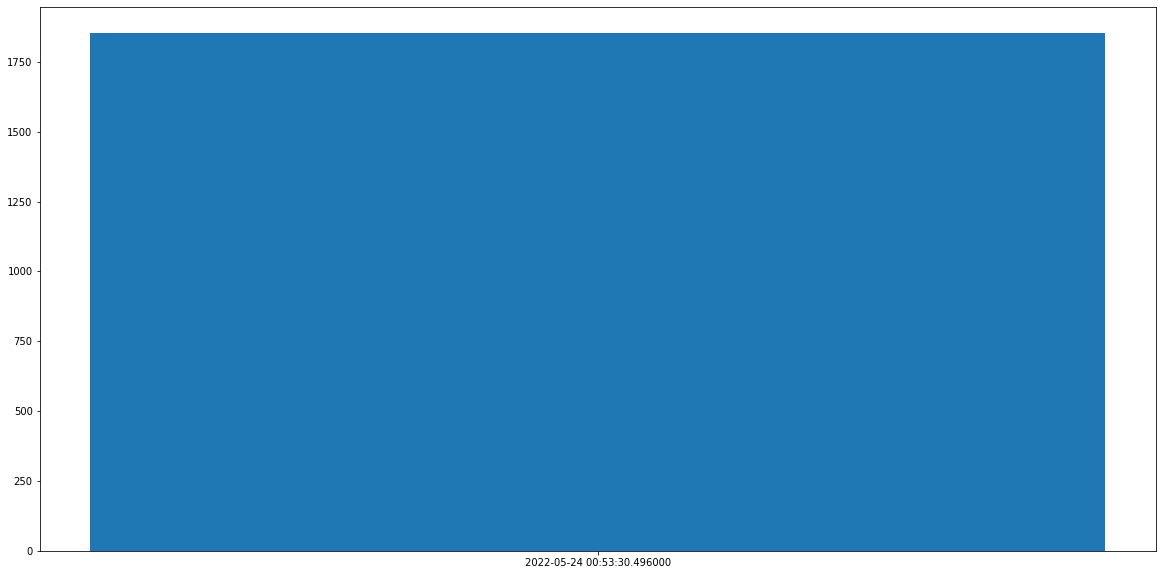

Latest Gold Price: 1853.533
Gold Price at: 2022-05-24 00:53:31.517000
-----------------------------------------


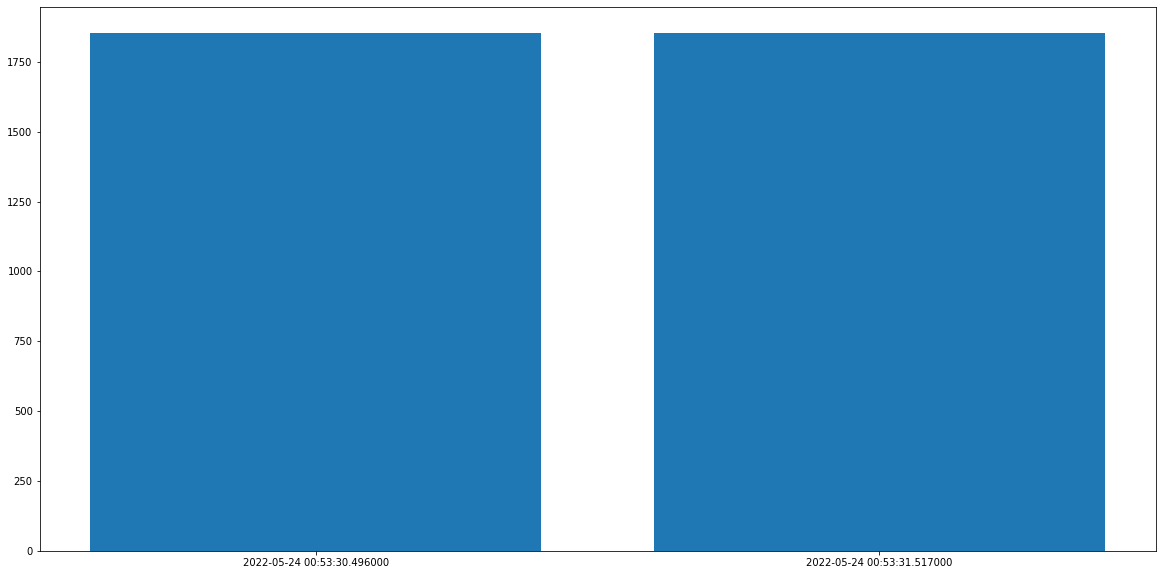

Latest Gold Price: 1853.563
Gold Price at: 2022-05-24 00:53:33.501000
-----------------------------------------


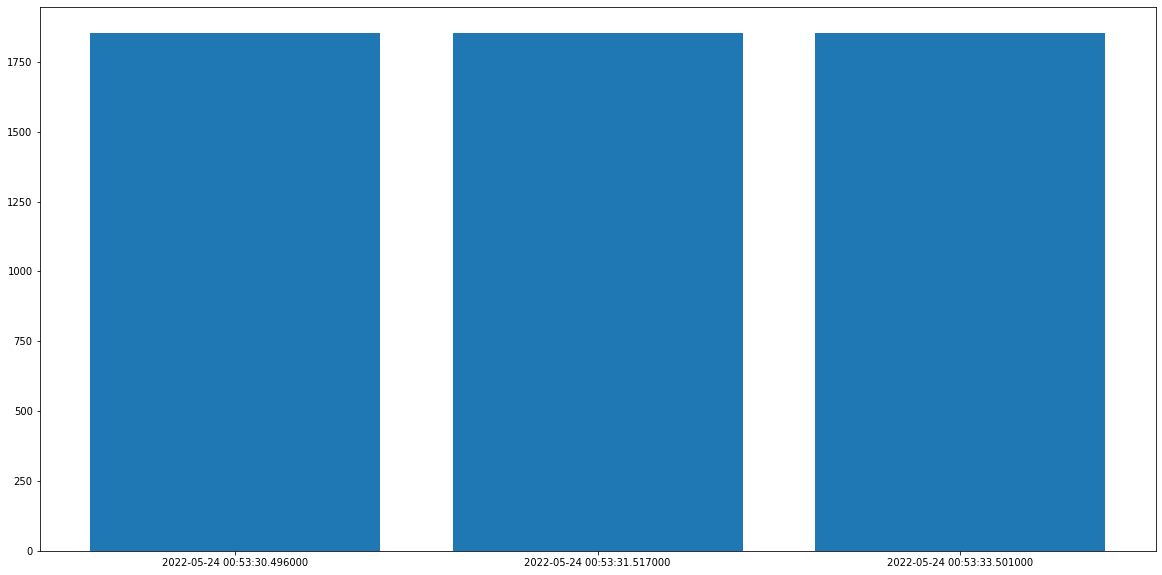

Latest Gold Price: 1853.503
Gold Price at: 2022-05-24 00:53:34.497000
-----------------------------------------


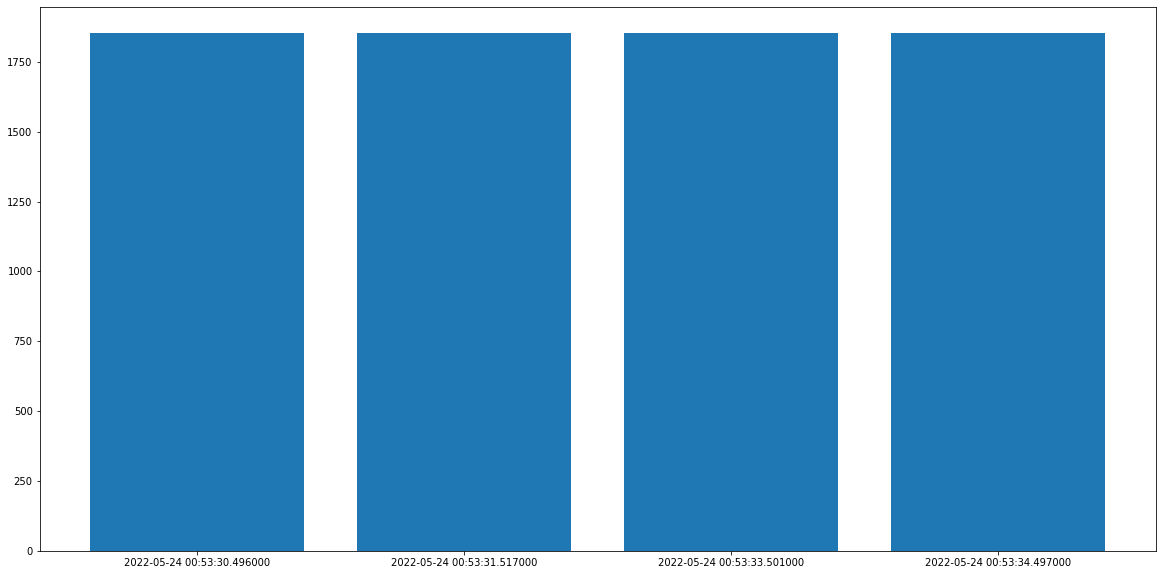

Latest Gold Price: 1853.493
Gold Price at: 2022-05-24 00:53:36.500000
-----------------------------------------


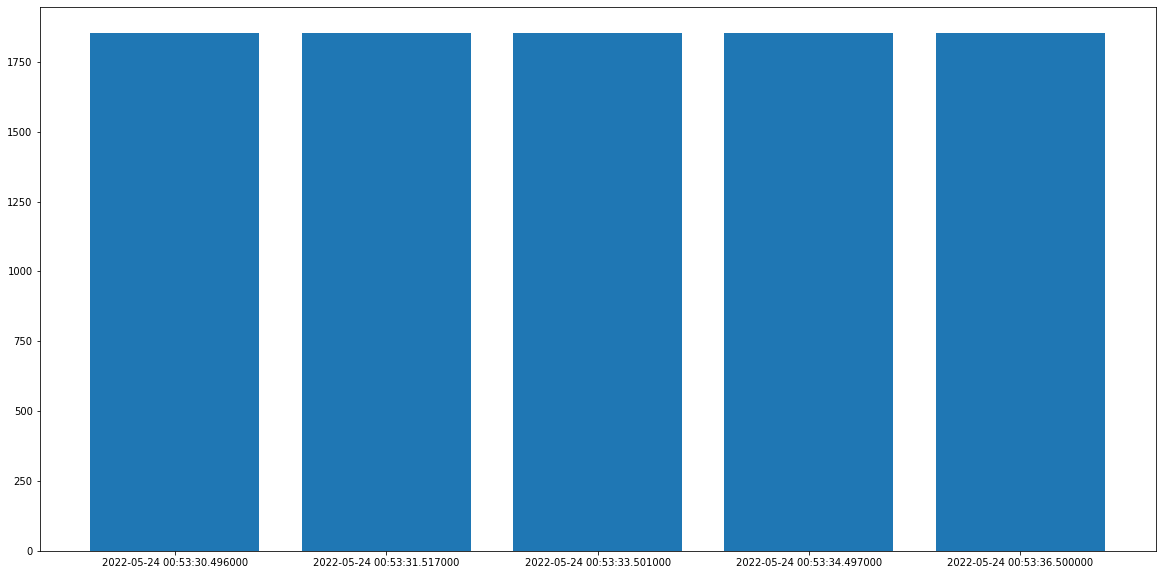

Latest Gold Price: 1853.513
Gold Price at: 2022-05-24 00:53:37.495000
-----------------------------------------


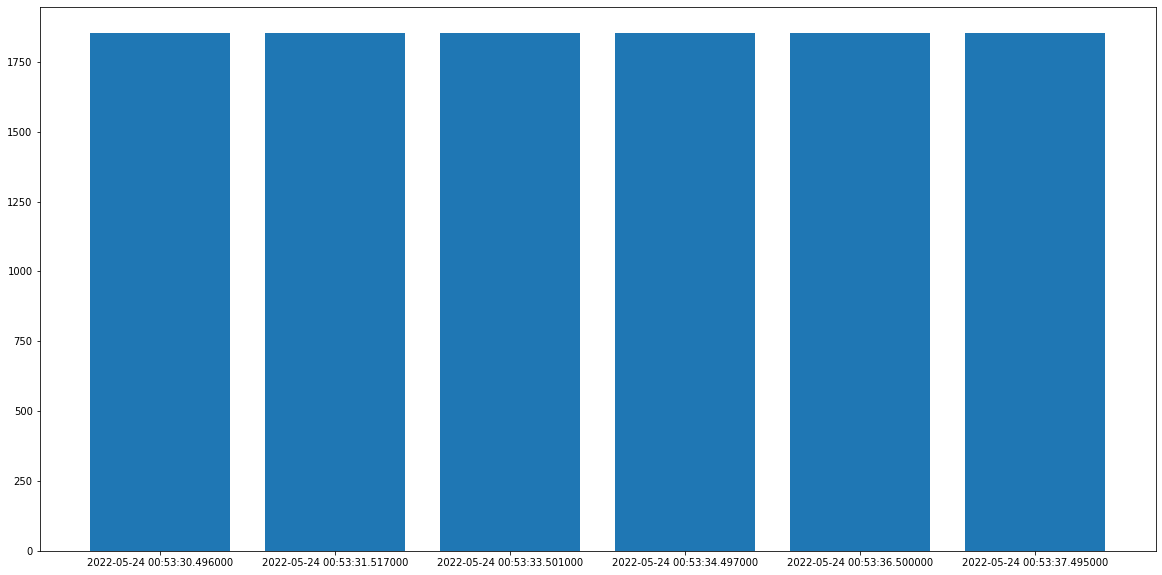

Latest Gold Price: 1853.517
Gold Price at: 2022-05-24 00:53:38.550000
-----------------------------------------


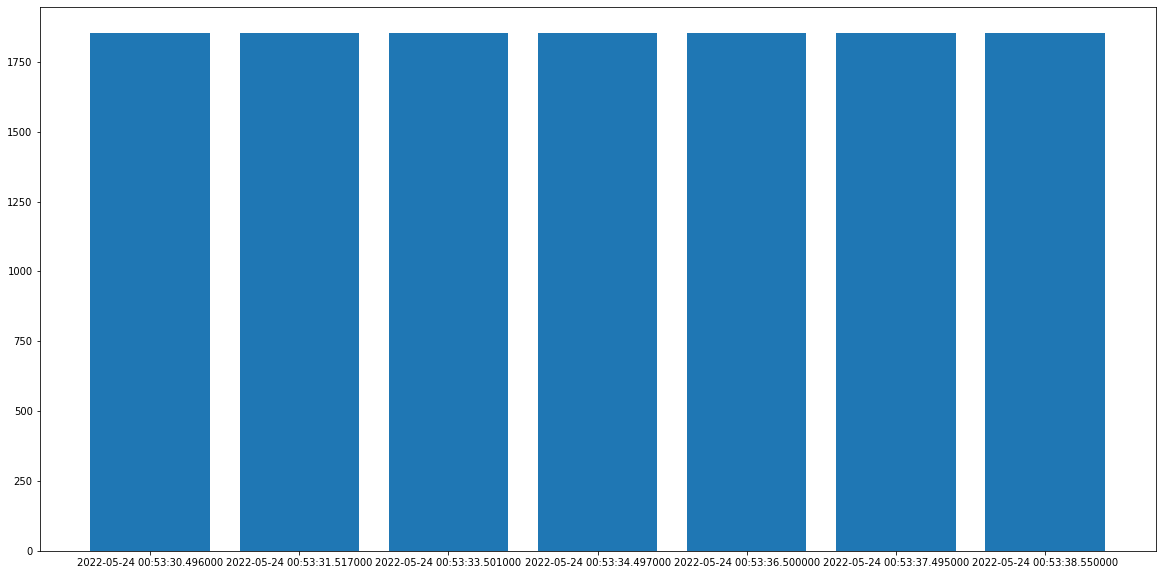

Latest Gold Price: 1853.483
Gold Price at: 2022-05-24 00:53:40.494000
-----------------------------------------


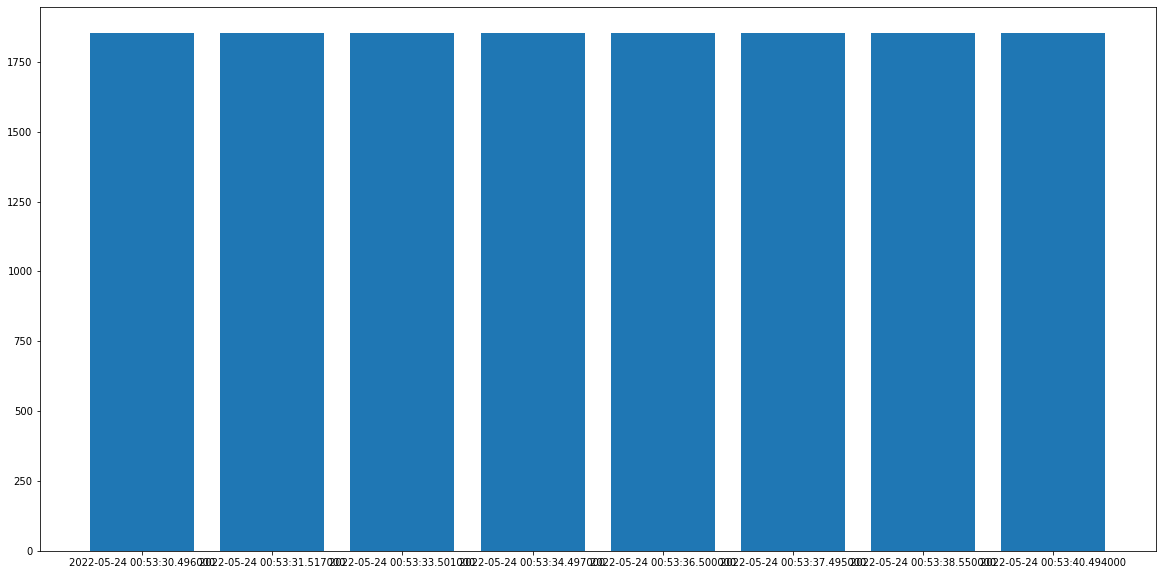

Latest Gold Price: 1853.493
Gold Price at: 2022-05-24 00:53:41.509000
-----------------------------------------


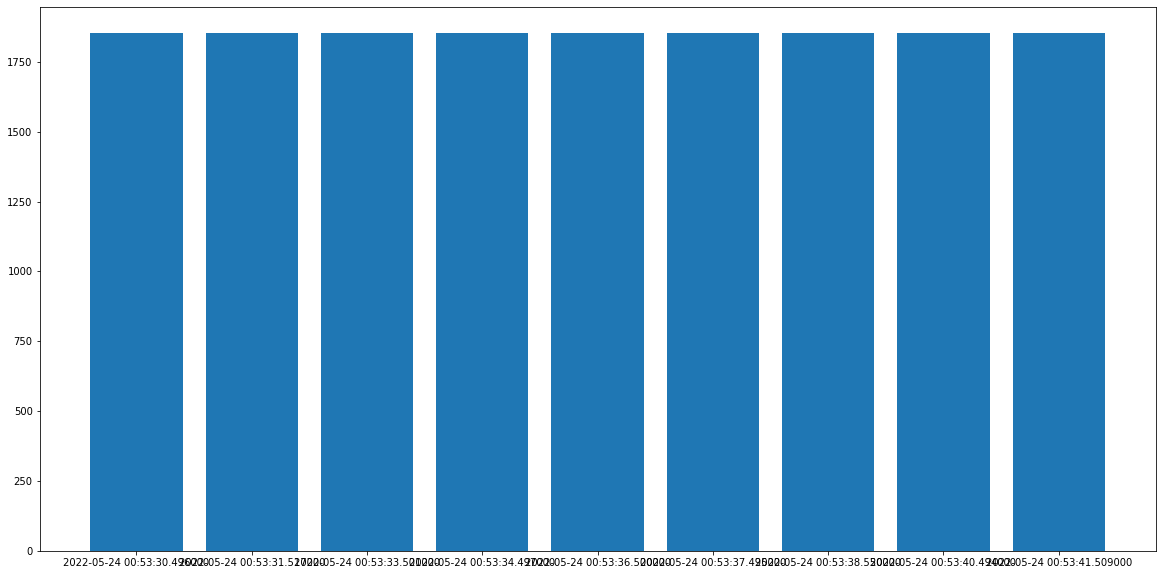

Latest Gold Price: 1853.493
Gold Price at: 2022-05-24 00:53:43.503000
-----------------------------------------


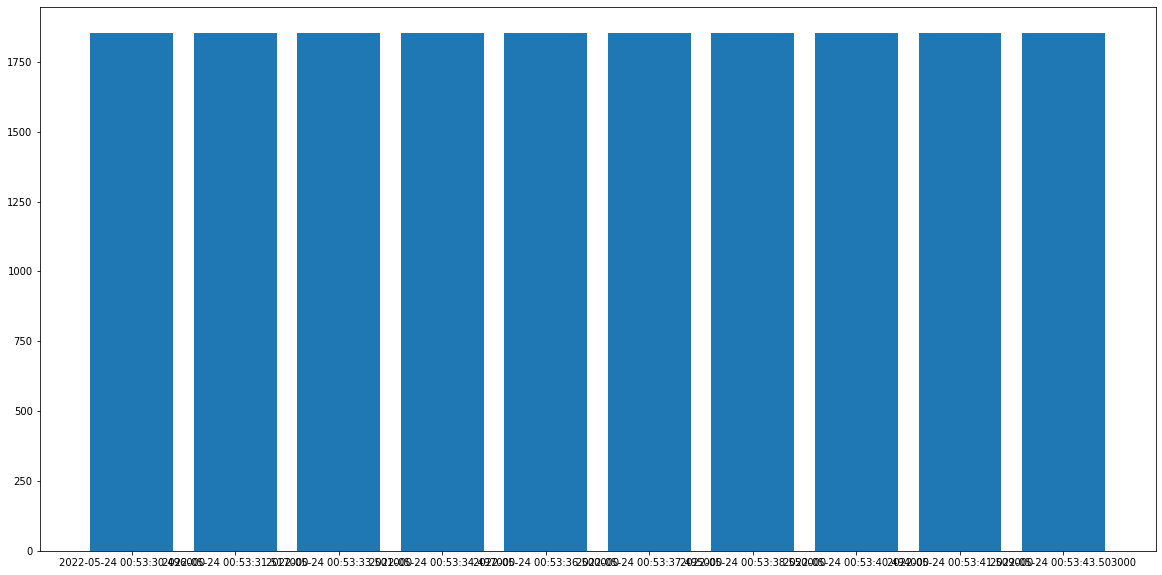

Latest Gold Price: 1853.493
Gold Price at: 2022-05-24 00:53:44.508000
-----------------------------------------


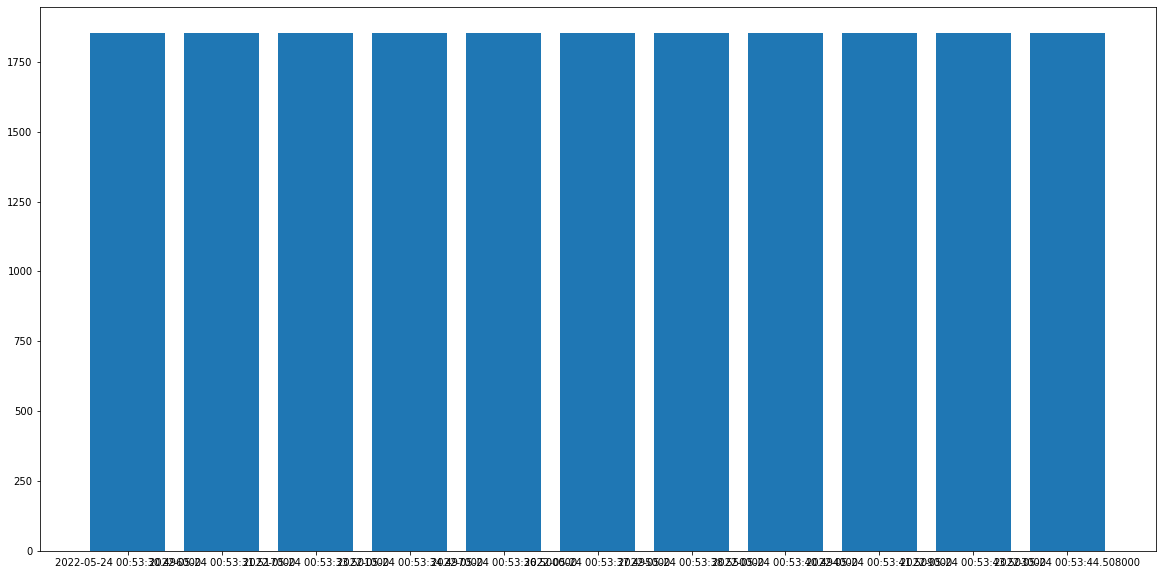

Latest Gold Price: 1853.515
Gold Price at: 2022-05-24 00:53:45.536000
-----------------------------------------


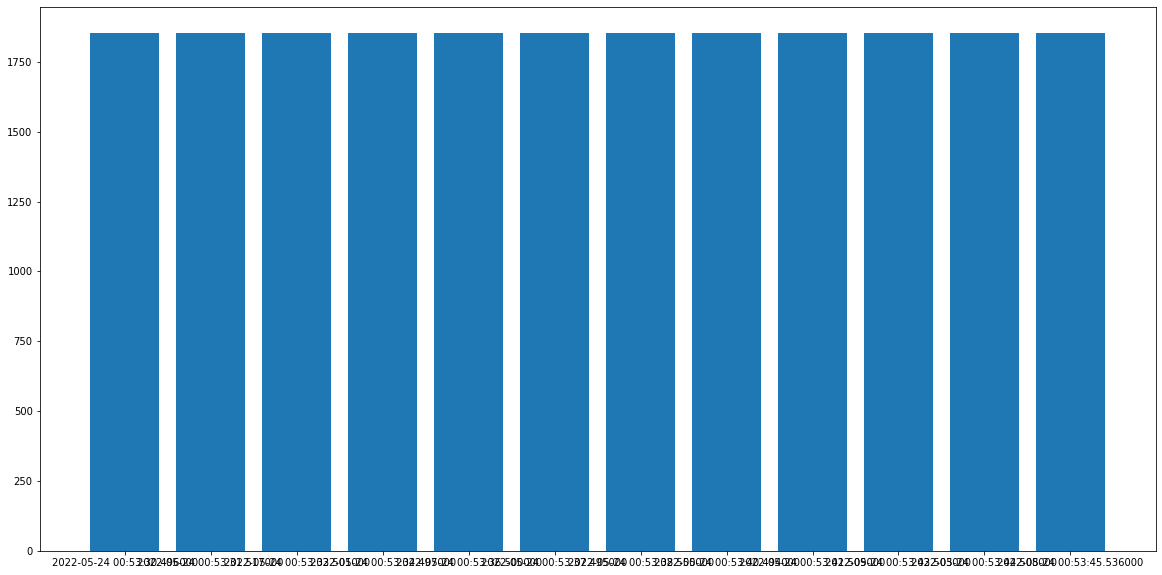

Latest Gold Price: 1853.403
Gold Price at: 2022-05-24 00:53:47.487000
-----------------------------------------


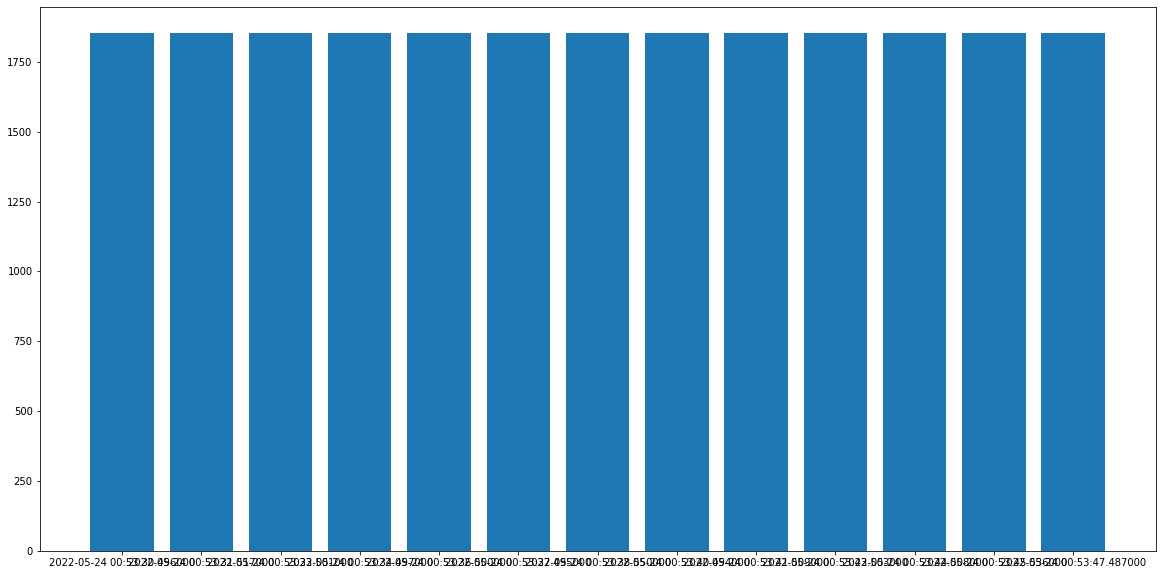

Latest Gold Price: 1853.393
Gold Price at: 2022-05-24 00:53:48.486000
-----------------------------------------


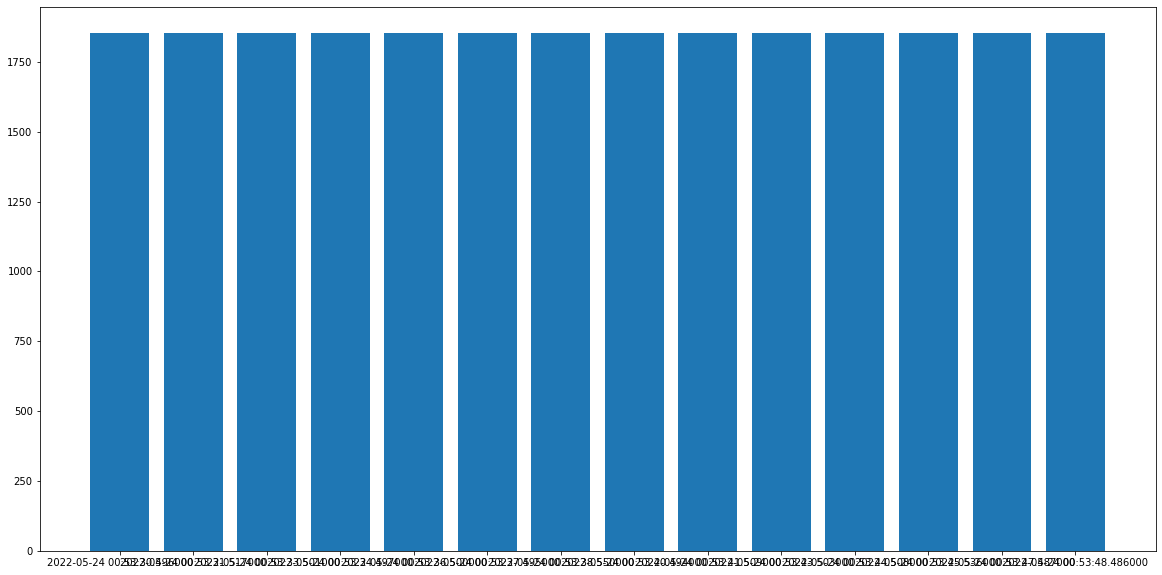

Latest Gold Price: 1853.403
Gold Price at: 2022-05-24 00:53:50.488000
-----------------------------------------


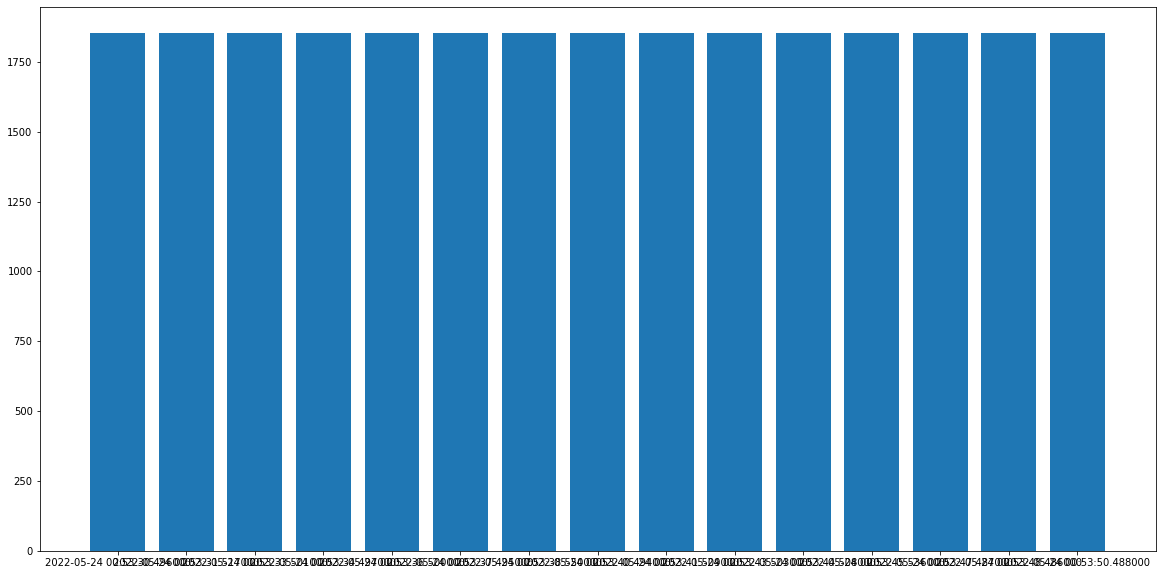

Latest Gold Price: 1853.423
Gold Price at: 2022-05-24 00:53:51.501000
-----------------------------------------


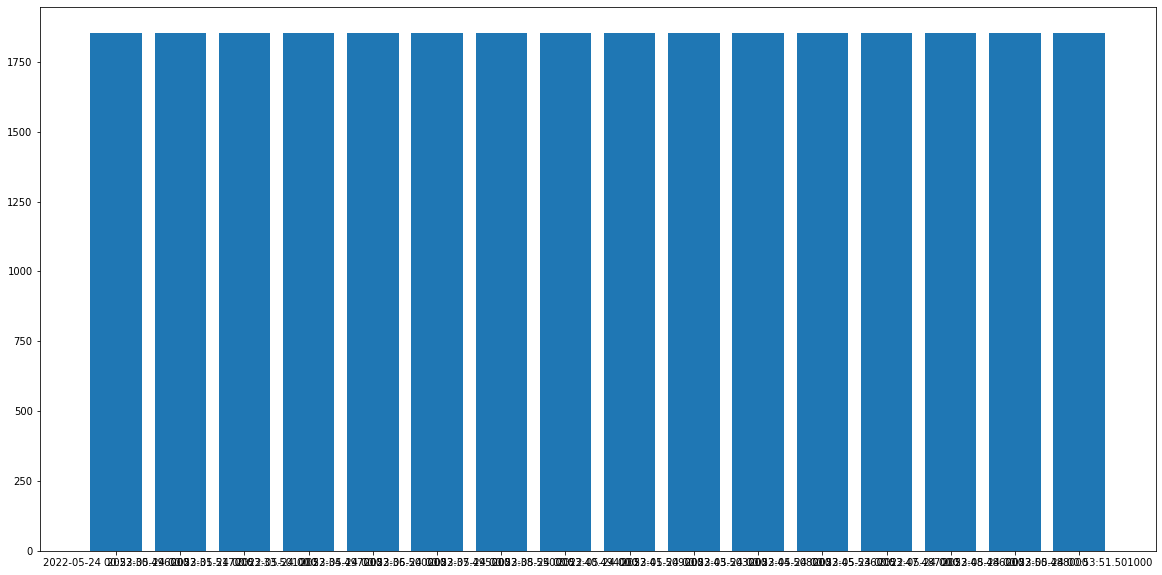

Latest Gold Price: 1853.437
Gold Price at: 2022-05-24 00:53:52.544000
-----------------------------------------


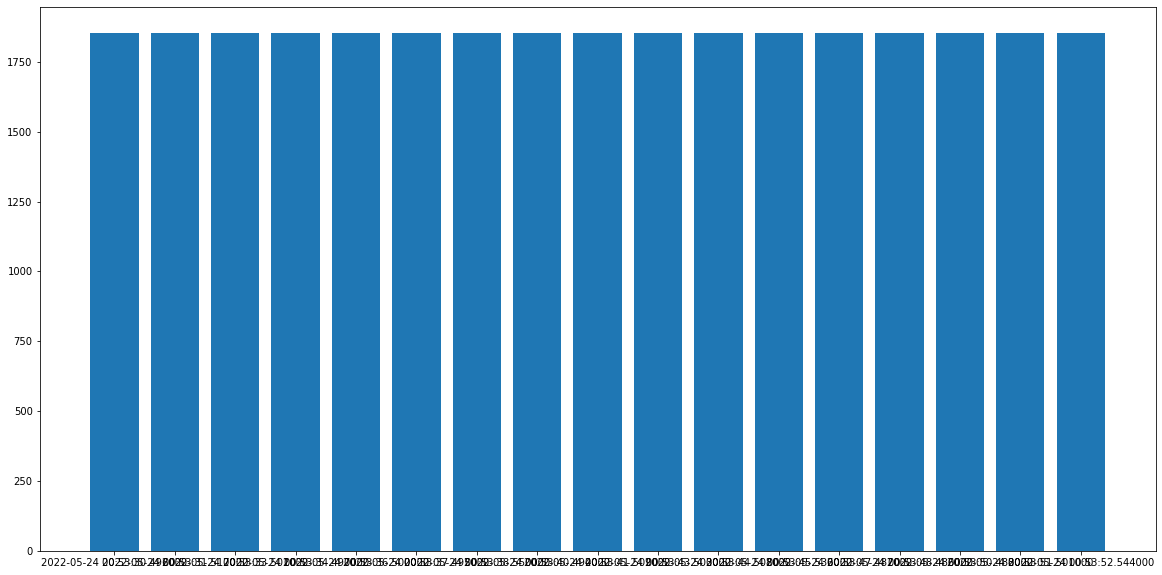

Latest Gold Price: 1853.483
Gold Price at: 2022-05-24 00:53:54.497000
-----------------------------------------


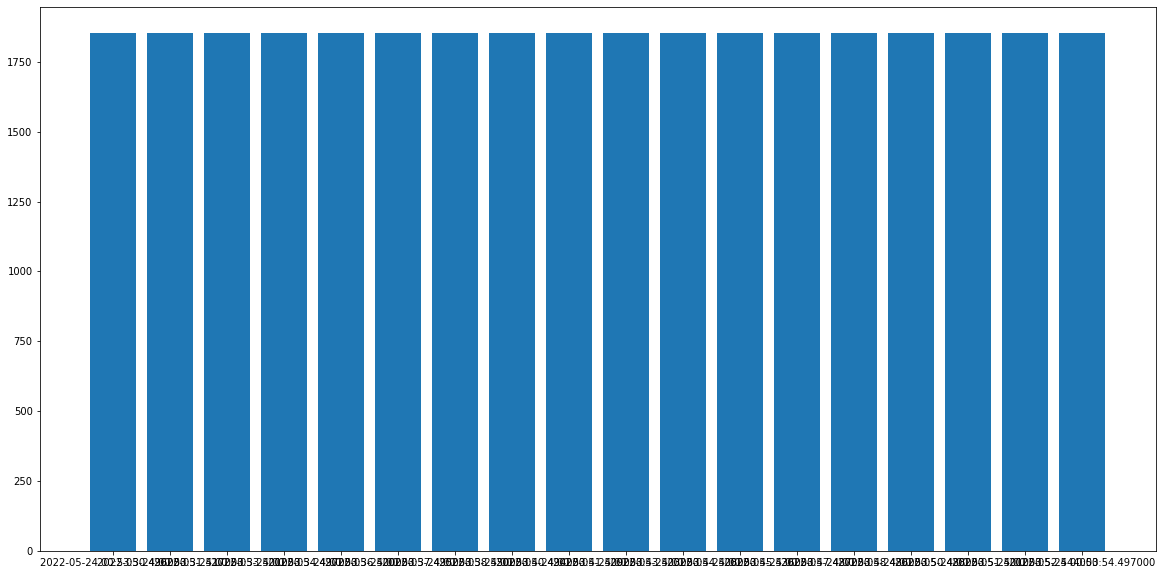

Latest Gold Price: 1853.443
Gold Price at: 2022-05-24 00:53:55.503000
-----------------------------------------


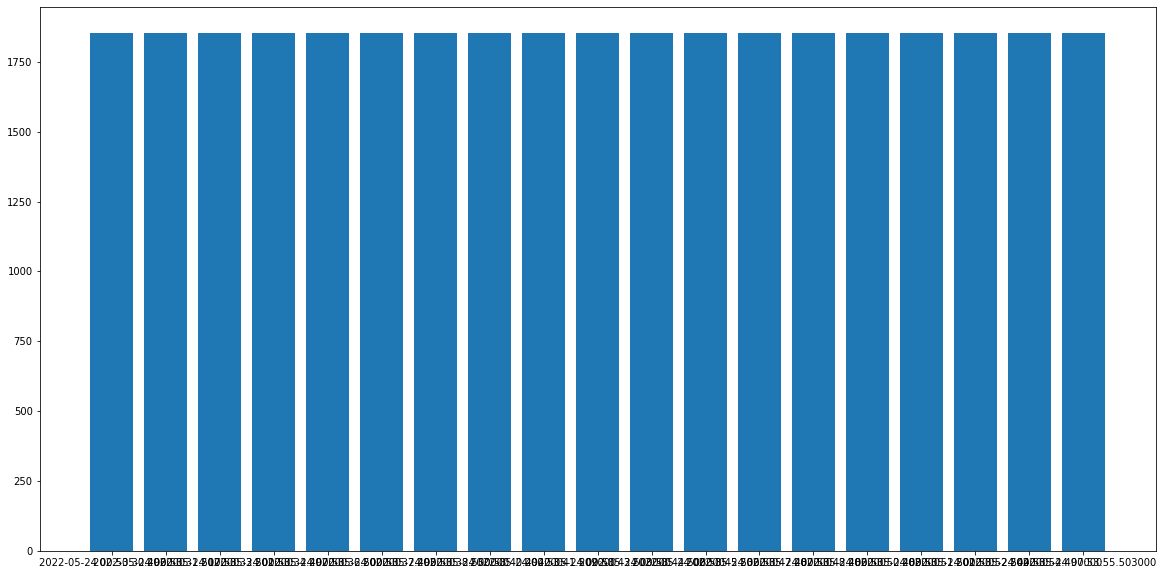

Latest Gold Price: 1853.463
Gold Price at: 2022-05-24 00:53:57.509000
-----------------------------------------


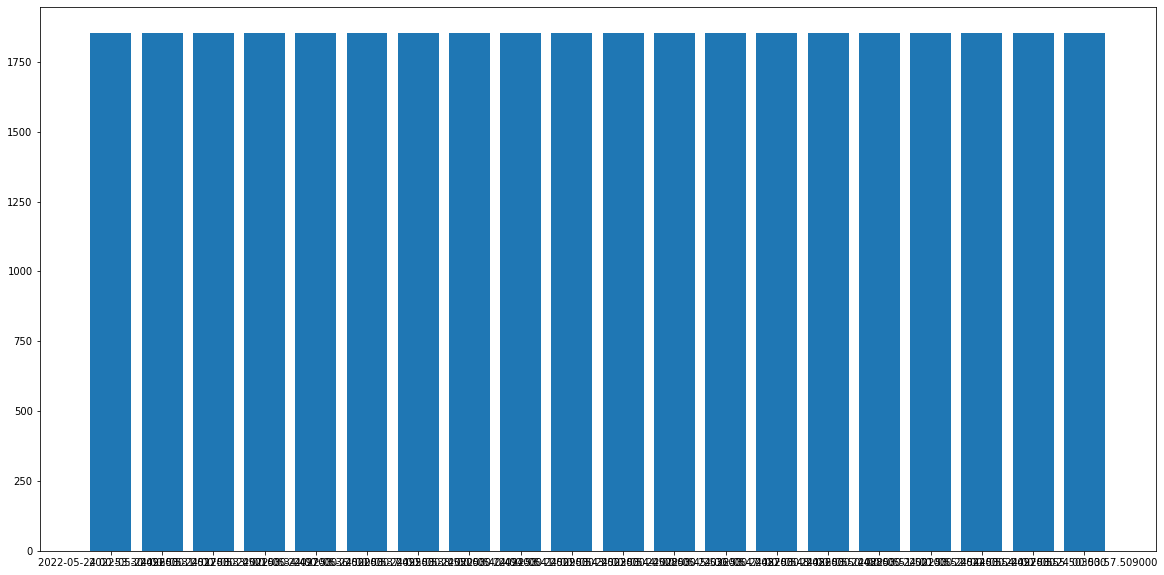

Latest Gold Price: 1853.463
Gold Price at: 2022-05-24 00:53:58.504000
-----------------------------------------


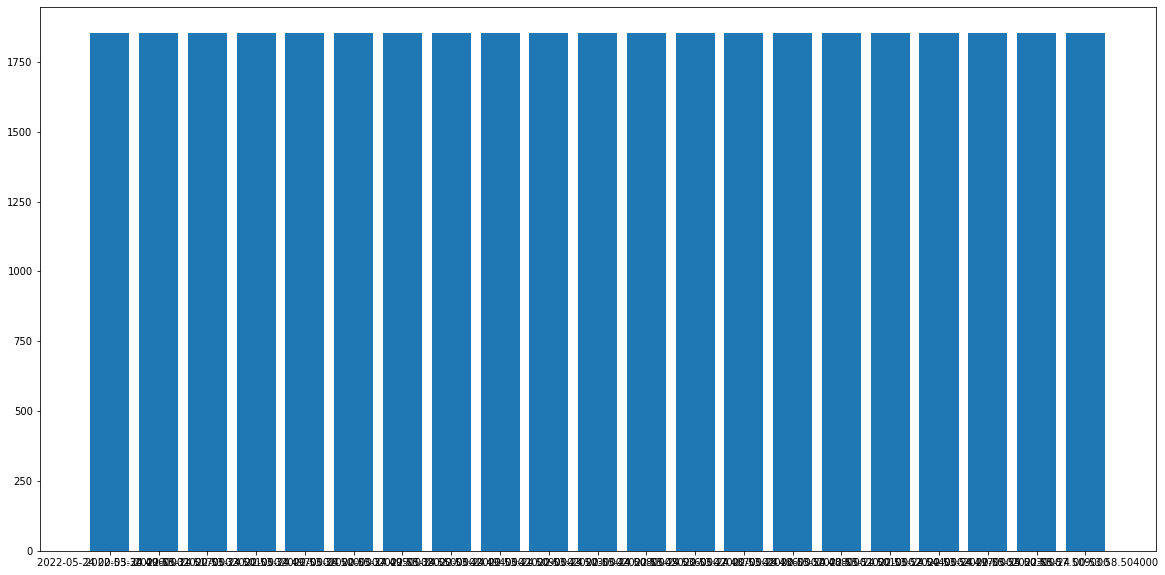

Latest Gold Price: 1853.463
Gold Price at: 2022-05-24 00:53:59.562000
-----------------------------------------


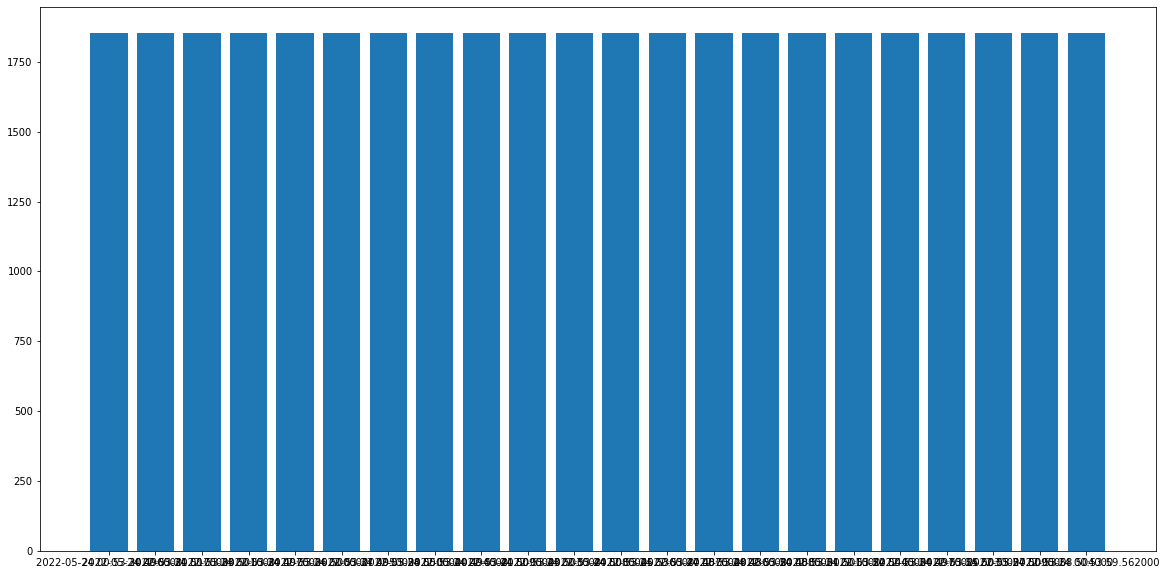

Latest Gold Price: 1853.433
Gold Price at: 2022-05-24 00:54:01.495000
-----------------------------------------


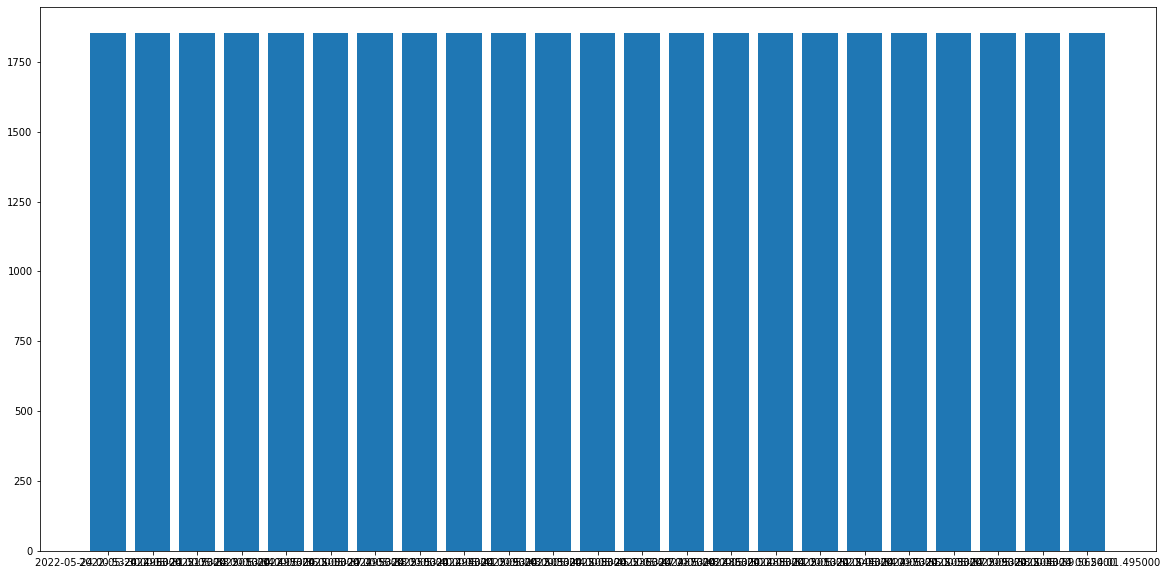

Latest Gold Price: 1853.393
Gold Price at: 2022-05-24 00:54:02.502000
-----------------------------------------


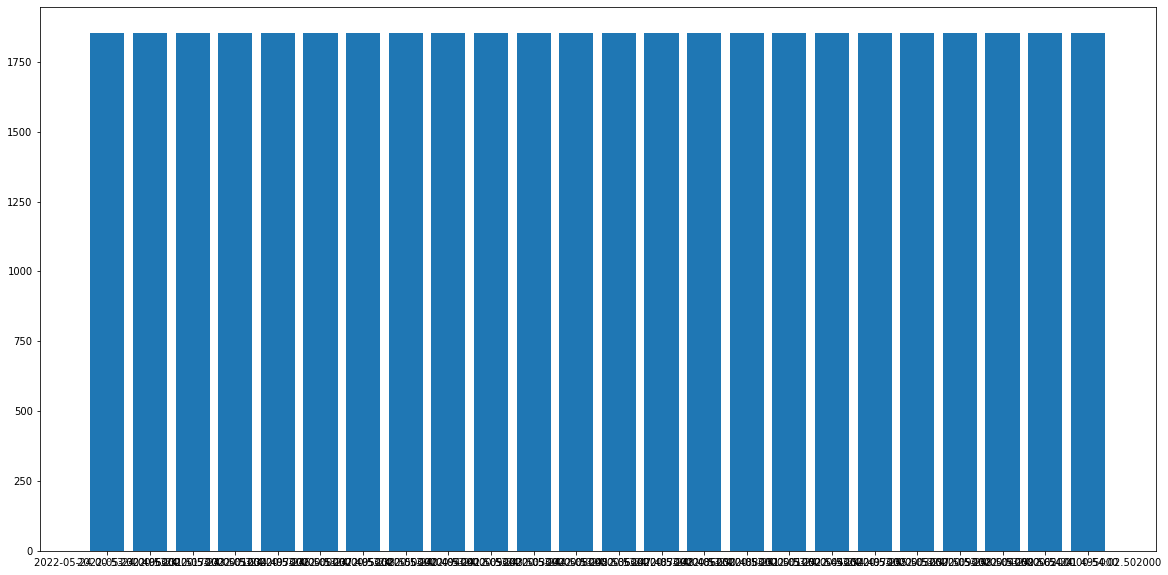

KeyboardInterrupt: ignored

In [ ]:
prev_price=0
goldprice_dict = {}
while(True):
    for message in consumer:
        #print(message)
        d=json.loads(message.value)
        df=DataFrame(d)
        for x in range(1):
            #print(x)
            new_price=df['spreadProfilePrices'][x][0]
            ts=df['ts'][x]
            #print(new_price)
            print("Latest Gold Price: " + str(new_price['ask']))
            datetime_time = datetime.fromtimestamp(ts/1000)
            goldprice_dict[str(datetime_time)]=new_price['ask']
            print("Gold Price at: " + str(datetime_time))
        print("-----------------------------------------")
        #print(goldprice_dict)
        plt.figure(figsize=(20,10))
        plt.bar(range(len(goldprice_dict)), list(goldprice_dict.values()), align='center',linewidth=0.5)
        plt.xticks(range(len(goldprice_dict)), list(goldprice_dict.keys()))
        plt.show()
        
    time.sleep(sleep_time)

In [ ]:
df.head(5)

,topo,spreadProfilePrices,ts
0,"{'platform': 'MT5', 'server': 'Live1'}","[{'spreadProfile': 'Prime', 'bidSpread': 11.4,...",1653353642502
1,"{'platform': 'MT4', 'server': 'Real2'}","[{'spreadProfile': 'Prime', 'bidSpread': 17.5,...",1653353642516
2,"{'platform': 'MT4', 'server': 'Live2'}","[{'spreadProfile': 'Standard', 'bidSpread': 6....",1653353642524
3,"{'platform': 'MT4', 'server': 'Live1'}","[{'spreadProfile': 'Prime', 'bidSpread': 11.4,...",1653353642527
4,"{'platform': 'MT4', 'server': 'RealUK'}","[{'spreadProfile': 'Prime', 'bidSpread': 17.5,...",1653353642539


In [ ]:
# Bid es el precio más alto que el comprador está dispuesto a pagar, y 
# ask el precio más bajo al que el vendedor está dispuesto a vender.
# El spread del precio bid es la diferencia entre el  precio más alto que el comprador 
# esta dispuesto a pagar por el bien (en este caso oro) y el minimo precio que el
# vendedor esta dispuesto a vender

#Para el oro prime
ask_price = df['spreadProfilePrices'][0][0]['ask'] 
bid_price = df['spreadProfilePrices'][0][0]['bid']

print(ask_price, bid_price)


1853.393 1853.066


# Clasificación suscripción de productos bancarios
## Explorando data bancaria


## Definición del problema

A continuación se presenta un set de datos obtenidos de una campaa de marketing de una institución bancaria. El objetivo de la campaña es determinar si el cliente se suscribirá o no al producto (depósito a plazo) y para esto, se realiza un modelo de clasificación binaria. En particular, se utilizará la regresión logística (enfoque más simple) y un Gradient-Boosted Tree Clasifier (enfoque más sofisticado). Para construir el modelo, así como para analizar y limpiar los datos, se utilizará PySpark.

In [ ]:
!pip install pyspark

El primer paso es importar las librerías que utilizaremos para construir e implementar el modelo

In [ ]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Montaremos también drive para así poder leer los datos almacenados en nuestro espacio

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
path = "/content/drive/MyDrive/Cursos/Data Science UDD/Big Data/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Damos una primera mirada al esquema de los datos, para entender las variables y qué papel jugará cada una en el modelo

In [ ]:
spark = SparkSession.builder.appName("Bank").getOrCreate()
df = spark.read.csv(path + 'bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


De lo anterior, podemos concluir que los inputs del modelo serán:
+ age
+ job
+ marital
+ education
+ default
+ balance
+ housing
+ loan
+ contact
+ day
+ month
+ duration
+ campaign
+ pdays
+ previous
+ poutcome

Mientras que la variable predecir o el label será:
+ deposit

A continuación checkeamos si el dataset se encuentra balanceado o no

In [ ]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


El dataset se encuentra balanceado, por lo que el siguiente paso será hacer estadística descriptiva sobre las variables numéricas del dataset, así como revisar la correlación entre las variables.

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


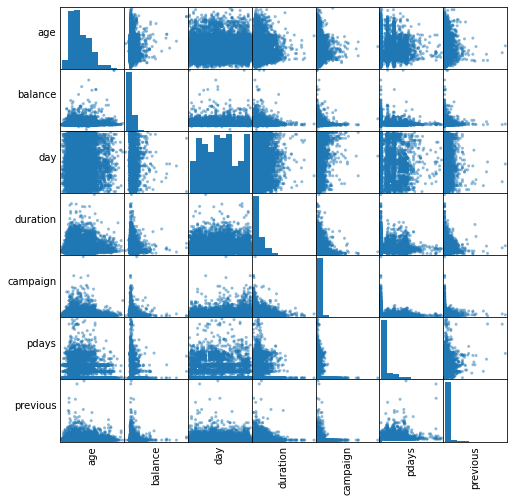

In [ ]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8), );
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Visualmente no se observan variables altamente correlacionada, por lo que, por ahora, conservamos todas las variables en el modelo, a excepción de día y mes, que para fines de la predicción no son relevantes.

In [ ]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



A continuación, trasnformaremos cada variable categórica para poder utilizarla como input del modelo. Para esto, lo primero que haremos, será indexar cada columna categórica con StringIndexer, luego aplicaremos un One Hot Encoding a cada columna categórica, aplicamos nuevament StringIndexer para trasnformar nuestras estiquetas en índices de etiquetas y por último aplicamos VectorAssembler para combinar todas las columnas de características en una sola vector column (esta columna se puede observar en el pandas df más abajo con el índice **feature**). 

In [ ]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    
    stages += [stringIndexer, encoder]

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

Usamos Pipeline para especificar el workflow de nuestro modelo

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


El último paso antes de comenzar con el modelo de clasificación consiste en dividir el dataset en entrenamiento y prueba

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


## Regresión logística

A continuación definimos e implementamos el modelo de regresión logística, obteniendo a su vez las métricas que nos permitan evaluar el desempeño del modelo:

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


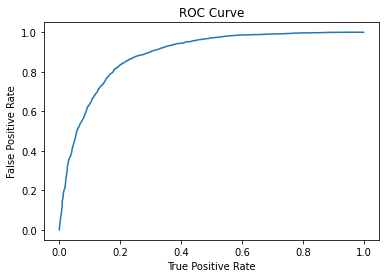

Training set areaUnderROC: 0.8877385690600346


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


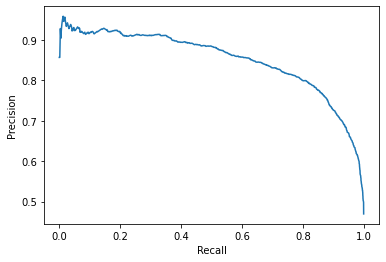

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------

In [ ]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


## Gradient-Boosted Tree Classifier

In [ ]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8935091626908479


Podemos observar que con el GBTClassifier obtuvimos mejores resultados que con nuestra regresión logística, po lo que a continuación, aplicaremos una grilla para hacer un *tuning* de los hiperparámetros, permitiéndonos afinar el modelo:

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8954659543871663

# Recomendación de películas
En el siguiente ejemplo verémos como utilizar Pyspark para trabajar con big data y entrenaremos un modelo para que recomiende películas que no han visto en base a una base de datos con información sobre como estos usuarios han calificado otras películas. Este es un ejemplo de como los servicios de streaming recomiendan peliculas a sus suscriptores y puede ser extrapolado a cualquier venta de productos o servicios, siempre y cuando se cuente con la data.

Instalamos pyspark en el notebook

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 53.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ef01cf95a7d88b11c46b7d4481619b13387f35606b7025d62fb409dc3d9f0e1d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Importamos las librerias necesarias

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [ ]:
# Creamos una SparkSession
spark = SparkSession.builder.appName('recommender_system').getOrCreate()

In [ ]:
# cargamos el dataset y lo leemos con spark para hacer un dataframe
df=spark.read.csv('/content/drive/MyDrive/Big_Data/movie_ratings_df.csv',inferSchema=True,header=True)
# Mostramos las primera 3 filas del dataframe
df.show(3)

+------+------------+------+
|userId|       title|rating|
+------+------------+------+
|   196|Kolya (1996)|     3|
|    63|Kolya (1996)|     3|
|   226|Kolya (1996)|     5|
+------+------------+------+
only showing top 3 rows



In [ ]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



Imprimimos el esquema del dataframe y vemos que tiene 3 columnas, el ID del usuario, el titulo de la pelicula y el rating que le dió a esa película ese usuario. Debido a que el titulo esta guardado como string, necesitamos transformarlo a valor numerico para poder utilizar la libreria MLlib de PySpark

In [ ]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
# Aplicamos el objeto stringindexer en la columna del titulo del dataframe
model = stringIndexer.fit(df)
#creamos el nuevo dataframe con los titulos de la pelicula transformados a valores numericos
indexed = model.transform(df)
#vemos el nuevo dataframe con la columna title_new que tiene valores numericos
indexed.limit(5).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


Para entrenar nuestro modelo utilizaremos un filtro colaborativo, el cual consiste en rellenar informacion de un usuario en base a factores latentes. Para rellenar esta informacion, utilizaremos especificamente el algoritmo ALS (Alternating Least Squares).

In [ ]:
# dividimos la data en entrenamiento y prueba
train, test = indexed.randomSplit([0.75,0.25])
# Importamos el algoritmo ALS
from pyspark.ml.recommendation import ALS

#Entrenamos el modelo recomendador usando el dataset de entrenamiento
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#"fiteamos" el modelos al set de entrenamiento
rec_model=rec.fit(train)

#Realizamos las predicciones en el set de prueba
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,148,Brazil (1985),4,109.0,4.647859
1,148,"Deer Hunter, The (1978)",1,280.0,6.328695
2,148,Fantasia (1940),5,153.0,4.029494
3,148,Four Weddings and a Funeral (1994),5,66.0,3.274741
4,148,"Good, The Bad and The Ugly, The (1966)",2,223.0,4.576540


Podemos ver que se ha añadido una nueva columna, la que corresponde a la prediccion. Esta columna le otorga un puntaje por pelicula a cada userId, el cual determina si a una persona se le recomendara cierta pelicula y a cual no (a mayor numero mas cerca de sus propios gustos).

A continuación, evaluamos el entrenamiento

In [ ]:
# Importamos el evaluador de regresion para medir RMSE
from pyspark.ml.evaluation import RegressionEvaluator
# Creamos el eobjeto para medir la precision
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
# aplicamos el evaluador en las predicciones del dataframe para calcular RMSEE
rmse=evaluator.evaluate(predicted_ratings)
# imprimimos el RMSE
print(rmse)

1.0339732622503393


Ahora crearemos una funcion para determinar el top de peliculas recomendadas para cada usuario

In [ ]:
# Primero creamos un dataset con cada pelicula individualizada
unique_movies=indexed.select('title_new').distinct()

#creamos la funcion "top_movies" para seleccionar el top n de peliculas para determinado usuario
def top_movies(user_id,n):
    """
    Esta funcion devuelve el top 'n' de peliculas que el usuario no ha visto aun pero podrian gustarle 
    
    """
    #le asignamos el alias 'a' al dataframe de peliculas individualizadas
    a = unique_movies.alias('a')
    
    #creamos otro df que contenga las peliculas ya vistas por el usuario a recomendar 
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')
    
    #le asignamos el alias 'b' al dataframe de peliculas ya vistas
    b=watched_movies.alias('b')
    
    #unimos ambos df con la funcion "left join" 
    total_movies = a.join(b, a.title_new == b.title_new,how='left')
    
    #seleccionamos las peliculas que el usuario aun no ha rankeado ni visto
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    
    #le agregamos una columna con el Id del usuario al df de las peliculas por ver/a recomendar 
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))
    
    #realizamos las recomendaciones utilizando el algoritmo ALS y seleccionamos las 'n' peliculas top
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)
    
    #agregamos los nombres de las peliculas al df de recomendaciones finales
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    #imprimimos las recomendaciones para el usuario seleccionado
    return final_recommendations.show(n,False)

In [ ]:
#recomendacion de 5 peliculas para el usuario de id=30
top_movies(30,5)

+---------+------+----------+--------------------------------+
|title_new|userId|prediction|title                           |
+---------+------+----------+--------------------------------+
|1013.0   |30    |10.370202 |Go Fish (1994)                  |
|843.0    |30    |9.593432  |Love! Valour! Compassion! (1997)|
|921.0    |30    |9.543929  |For Whom the Bell Tolls (1943)  |
|1040.0   |30    |9.066699  |Boys of St. Vincent, The (1993) |
|1265.0   |30    |9.025103  |Duoluo tianshi (1995)           |
+---------+------+----------+--------------------------------+



De esta forma se puede implementar una funcion de recomendaciones sobre un gran numero de información en formato df de spark. Este algoritmo resulta bastante sencillo de aplicar y esta optimizado para funcionar con spark, por lo que es bastante eficiente con respecto al tiempo al momento de implementarlo.

# Analisis de historial de ventas

El objetivo del caso es explorar un historial de un millon de ventas de una base de datos de muestra, utilizando pyspark y analizando mas a profundidad con SQL.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [4]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import pyspark.sql
from pyspark.sql.functions import col
from pyspark.context import SparkContext
import time

In [5]:
spark = SparkSession.builder.getOrCreate()

In [33]:
df1 = spark.read.options(header=True, inferSchema=True, delimiter=";").csv('Data1.csv')
df2 = spark.read.options(header=True, inferSchema=True, delimiter=";").csv('data2.csv')

In [34]:
df = df1.unionByName(df2)

In [35]:
print("Data shape:", df.count(), "x", len(df.columns))

Data shape: 1067371 x 8


In [36]:
df.limit(5).show()

+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
| 536365|   85123A|WHITE HANGING HEA...|       6| 01-12-2010| 2,55|      17850|United Kingdom|
| 536365|    71053| WHITE METAL LANTERN|       6| 01-12-2010| 3,39|      17850|United Kingdom|
| 536365|   84406B|CREAM CUPID HEART...|       8| 01-12-2010| 2,75|      17850|United Kingdom|
| 536365|   84029G|KNITTED UNION FLA...|       6| 01-12-2010| 3,39|      17850|United Kingdom|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6| 01-12-2010| 3,39|      17850|United Kingdom|
+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+



In [37]:
summary = df.describe().toPandas()
summary = summary.T
summary.columns = summary.iloc[0]
summary = summary.drop(summary.index[0])
summary

summary,count,mean,stddev,min,max
Invoice,1067371,537608.1499316233,26662.450446910476,489434,C581569
StockCode,1067371,29011.161534536903,18822.942866189307,10002,m
Description,1062989,21848.25,922.9197780233488,DOORMAT UNION JACK GUNS AND ROSES,wrongly sold sets
Quantity,1067371,9.9388984711033,172.70579407675444,-80995,80995
InvoiceDate,1067371,None,None,01-02-2010,31-10-2011
Price,1067371,19.92448124501197,400.46793090926843,"-11062,06","99,96"
Customer ID,824364,15324.63850435002,1697.4644503793115,12346,18287
Country,1067371,None,None,Australia,West Indies


In [38]:
from pyspark.sql.functions import isnan, count, col, when

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]) # Funcion encontrada en sparkbyexamples.com

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,4382,0,0,0,243007,0


In [39]:
df.schema 
# StructField(Price,StringType,true) --> Podemos ver que el precio es String, debe ser cambiado.
# StructField(Quantity,IntegerType,true) --> Quantity debe ser Float.

StructType(List(StructField(Invoice,StringType,true),StructField(StockCode,StringType,true),StructField(Description,StringType,true),StructField(Quantity,IntegerType,true),StructField(InvoiceDate,StringType,true),StructField(Price,StringType,true),StructField(Customer ID,IntegerType,true),StructField(Country,StringType,true)))

In [40]:
df.describe

<bound method DataFrame.describe of +-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
| 536365|   85123A|WHITE HANGING HEA...|       6| 01-12-2010| 2,55|      17850|United Kingdom|
| 536365|    71053| WHITE METAL LANTERN|       6| 01-12-2010| 3,39|      17850|United Kingdom|
| 536365|   84406B|CREAM CUPID HEART...|       8| 01-12-2010| 2,75|      17850|United Kingdom|
| 536365|   84029G|KNITTED UNION FLA...|       6| 01-12-2010| 3,39|      17850|United Kingdom|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6| 01-12-2010| 3,39|      17850|United Kingdom|
| 536365|    22752|SET 7 BABUSHKA NE...|       2| 01-12-2010| 7,65|      17850|United Kingdom|
| 536365|    21730|GLASS STAR FROSTE...|       6| 01-12-2010| 4,25|      17850|United Kingdom|
| 536366|    2

In [41]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("Quantity", col("Quantity").cast("Float"))
df = df.withColumn('Price', regexp_replace('Price', ',', '.').cast('float'))

In [42]:
df.groupby("InvoiceDate").count().sort("InvoiceDate", ascending=True).limit(10)

InvoiceDate,count
01-02-2010,1399
01-02-2011,1574
01-03-2010,1230
01-03-2011,1361
01-04-2010,1719
01-04-2011,1261
01-05-2011,452
01-06-2010,1224
01-06-2011,1456
01-07-2010,1858


In [43]:
df = df.withColumn("Amount", col("Quantity") * col("Price"))
df.limit(5)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
536365,85123A,WHITE HANGING HEA...,6.0,01-12-2010,2.55,17850,United Kingdom,15.299999
536365,71053,WHITE METAL LANTERN,6.0,01-12-2010,3.39,17850,United Kingdom,20.34
536365,84406B,CREAM CUPID HEART...,8.0,01-12-2010,2.75,17850,United Kingdom,22.0
536365,84029G,KNITTED UNION FLA...,6.0,01-12-2010,3.39,17850,United Kingdom,20.34
536365,84029E,RED WOOLLY HOTTIE...,6.0,01-12-2010,3.39,17850,United Kingdom,20.34


In [44]:
# Busqueda de descripciones (Solo para revisar)
df[df.Description.like('%WHITE%')].limit(5)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
536365,85123A,WHITE HANGING HEA...,6.0,01-12-2010,2.55,17850,United Kingdom,15.299999
536365,71053,WHITE METAL LANTERN,6.0,01-12-2010,3.39,17850,United Kingdom,20.34
536365,84029E,RED WOOLLY HOTTIE...,6.0,01-12-2010,3.39,17850,United Kingdom,20.34
536373,85123A,WHITE HANGING HEA...,6.0,01-12-2010,2.55,17850,United Kingdom,15.299999
536373,71053,WHITE METAL LANTERN,6.0,01-12-2010,3.39,17850,United Kingdom,20.34


In [45]:
# Grandes compras, solo en UK y Dinamarca
df.filter(df.Quantity > 10000).limit(20)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
541431,23166,MEDIUM CERAMIC TO...,74215.0,18-01-2011,1.04,12346,United Kingdom,77183.59
578841,84826,ASSTD DESIGN 3D P...,12540.0,25-11-2011,0.0,13256,United Kingdom,0.0
581483,23843,"PAPER CRAFT , LIT...",80995.0,09-12-2011,2.08,16446,United Kingdom,168469.6
497946,37410,BLACK AND WHITE P...,19152.0,15-02-2010,0.1,13902,Denmark,1915.2001
501534,21099,SET/6 STRAWBERRY ...,12960.0,17-03-2010,0.1,13902,Denmark,1296.0
501534,21092,SET/6 STRAWBERRY ...,12480.0,17-03-2010,0.1,13902,Denmark,1248.0
501534,21091,SET/6 WOODLAND PA...,12960.0,17-03-2010,0.1,13902,Denmark,1296.0
501534,21085,SET/6 WOODLAND PA...,12744.0,17-03-2010,0.1,13902,Denmark,1274.4
507637,84016,FLAG OF ST GEORGE...,10200.0,10-05-2010,0.0,null,United Kingdom,0.0


In [46]:
# Donde fue la mayor cantidad de compras
df.groupBy("Country").count().sort("count", ascending=False).limit(10)
# EIRE = Irlanda

Country,count
United Kingdom,981330
EIRE,17866
Germany,17624
France,14330
Netherlands,5140
Spain,3811
Switzerland,3189
Belgium,3123
Portugal,2620
Australia,1913


In [49]:
df.registerTempTable("df")

In [50]:
import pyspark.sql

spark.sql("""SELECT Description, Quantity, Country 
            FROM df 
            WHERE Quantity > 100 AND Country = 'United Kingdom'
            ORDER BY Quantity DESC""").limit(20)

Description,Quantity,Country
"PAPER CRAFT , LIT...",80995.0,United Kingdom
MEDIUM CERAMIC TO...,74215.0,United Kingdom
ASSTD DESIGN 3D P...,12540.0,United Kingdom
FLAG OF ST GEORGE...,10200.0,United Kingdom
PACK OF 12 PINK P...,10000.0,United Kingdom
PACK OF 12 RED SP...,10000.0,United Kingdom
PACK OF 12 SUKI T...,10000.0,United Kingdom
PACK OF 12 WOODLA...,10000.0,United Kingdom
null,9600.0,United Kingdom
ROTATING SILVER A...,9360.0,United Kingdom


In [51]:
spark.sql("SELECT COUNT(DISTINCT Country) from df")

count(DISTINCT Country)
43


In [52]:
spark.sql("""SELECT Description, Quantity, Country 
            FROM df 
            WHERE Quantity>100 AND NOT Country = 'United Kingdom'
            ORDER BY Quantity DESC""").limit(20)

Description,Quantity,Country
BLACK AND WHITE P...,19152.0,Denmark
SET/6 STRAWBERRY ...,12960.0,Denmark
SET/6 WOODLAND PA...,12960.0,Denmark
SET/6 WOODLAND PA...,12744.0,Denmark
SET/6 STRAWBERRY ...,12480.0,Denmark
SMALL FAIRY CAKE ...,9456.0,Denmark
JAZZ HEARTS MEMO PAD,9312.0,Denmark
SET/6 FRUIT SALAD...,7128.0,France
SET/6 FRUIT SALAD...,7008.0,France
JAZZ HEARTS MAGNE...,6768.0,Denmark


In [53]:
spark.sql("""SELECT Description, Amount, Country 
            FROM df 
            WHERE Quantity>100 AND Country = 'United Kingdom'
            ORDER BY Amount DESC""").limit(20)

Description,Amount,Country
"PAPER CRAFT , LIT...",168469.6,United Kingdom
MEDIUM CERAMIC TO...,77183.59,United Kingdom
ROTATING SILVER A...,15818.4,United Kingdom
PINK PAPER PARASOL,8925.0,United Kingdom
SET OF TEA COFFEE...,7144.7197,United Kingdom
FAIRY CAKE FLANNE...,6539.4,United Kingdom
FAIRY CAKE FLANNE...,6539.4,United Kingdom
PAPER CHAIN KIT 5...,5803.25,United Kingdom
ROTATING SILVER A...,5179.1997,United Kingdom
WHITE HANGING HEA...,4921.5,United Kingdom


In [54]:
spark.sql("""SELECT Description, Amount, Country 
            FROM df 
            WHERE Quantity>100 AND NOT Country = 'United Kingdom'
            ORDER BY Amount DESC""").limit(20)

Description,Amount,Country
RABBIT NIGHT LIGHT,4992.0,Netherlands
ROUND SNACK BOXES...,3794.4,Japan
ROUND SNACK BOXES...,3794.4,Japan
RABBIT NIGHT LIGHT,3651.5999,Japan
SMALL FAIRY CAKE ...,3630.8,Denmark
SMALL FAIRY CAKE ...,2836.8,Denmark
RABBIT NIGHT LIGHT,2577.5999,Netherlands
RED RETROSPOT CAK...,2365.2,EIRE
POLKADOT CUTLERY ...,1990.0,EIRE
BLACK AND WHITE P...,1915.2001,Denmark


In [55]:
# Claramente la fuente principal de ingresos es UK.
from pyspark.sql.functions import lit

# Asi que se creara una columna nueva solo para analizar la diferencia entre UK y los otros paises
df = df.withColumn('Country_UK', lit(0))
df = df.withColumn("Country_UK", when(df["Country"] == 'United Kingdom', 1).otherwise(df["Country_UK"]))

In [56]:
df.groupBy("Country_UK").count()

Country_UK,count
1,981330
0,86041


In [57]:
df.groupBy("Country_UK").agg({"Amount": "mean", "Quantity": "sum"})

Country_UK,avg(Amount),sum(Quantity)
1,16.69426579423943,8692875.0
0,33.75909931988668,1915617.0
